# Setup

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Suppress unnecessary warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Load

In [3]:
data = pd.read_csv("jsed_curve_fit.csv"); data.head()

,x,y
0,1658.845908,332.613305
1,1645.428049,327.999507
2,1631.959513,325.608188
3,1618.488526,324.971874
4,1605.036794,324.247557


In [4]:
data.describe()

,x,y
count,197.000000,197.000000
mean,640.347605,213.647585
std,502.637343,67.680877
min,0.000000,77.671250
25%,178.475672,166.175834
50%,563.620186,211.905506
75%,1056.001593,269.394993
max,1658.845908,332.613305


# Exploration and Understanding

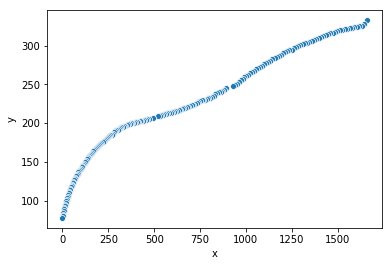

In [5]:
sns.scatterplot(x=data.x, y=data.y)

Early `x` values increase dramatically but then taper off and increase at a different linear rate. This would warrant two different piecewise linear regression functions. To find the most optimal, let's iteratively split at different `x` values to fit two linear regression functions, calculate the $R^2$ score, and maximize the score for both functions.

# Training Piece-Wise Model

In [6]:
# Keep track of R^2 scores of both linear functions
r1 = []
r2 = []
# Also keep track of both linear models while testing different splits
model1 = []
model2 = []

# The range of splits looks to be best between 1 and 100
splits = range(1, 101)

for split in splits:
    # Split x values
    x1 = data.sort_values('x')[data.x < split]
    x2 = data.sort_values('x')[data.x >= split]
    
    # Fit linear model on first set of x's
    linear_model1 = LinearRegression()
    linear_model1.fit(pd.DataFrame(x1.x), x1.y)
    model1.append(linear_model1)
    
    # Fit on the second set of x's
    linear_model2 = LinearRegression()
    linear_model2.fit(pd.DataFrame(x2.x), x2.y)
    model2.append(linear_model2)
    
    # Predict the values of y for each model
    line_x1 = linear_model1.predict(pd.DataFrame(x1.x))
    line_x2 = linear_model2.predict(pd.DataFrame(x2.x))
    
    # Calculate R^2 scores for both models
    r1.append(r2_score(x1.y, line_x1))
    r2.append(r2_score(x2.y, line_x2))

Plot the $R^2$ scores to determine optimized `x` split

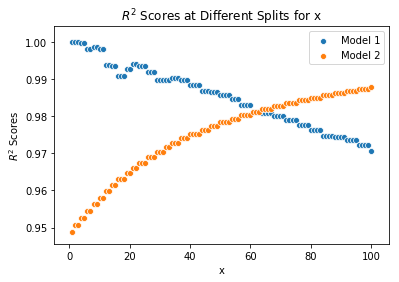

In [7]:
ax = sns.scatterplot(x=splits, y=r1, label="Model 1")
ax = sns.scatterplot(x=splits, y=r2, label="Model 2")
ax.set(title=r"$R^2$ Scores at Different Splits for x", xlabel="x", ylabel=r"$R^2$ Scores")
ax.legend()

Search through split values to determine exact value of `x` by seeing when model 1 $R^2$ scores fall at or below $R^2$ scores of model 2.

In [8]:
# Indecies are i - 1 since splits starts at 1
for i in splits:
    if r1[i-1] <= r2[i-1]:
        optimal_split = i - 1
        break
print(f"Optimal Split: {optimal_split}")

Optimal Split: 63


Obtain linear model for both piece-wise functions at the same index.

In [9]:
piece1 = model1[optimal_split]
piece2 = model2[optimal_split]

# Prediction with Piece-Wise Model

Predict all values of `y` for all of `x` through the piece-wise function. Any `x` values $\leq$ the optimal split is predicted with model 1 and values $\gt$ the optimal split is predicted with model 2.

In [10]:
# Create Predictions column
data['predictions'] = 0
data['predictions'][data.x <= optimal_split] = piece1.predict(pd.DataFrame(data.x[data.x <= optimal_split]))
data['predictions'][data.x > optimal_split] = piece2.predict(pd.DataFrame(data.x[data.x > optimal_split]))

# Performance Evaluation

In [11]:
# Final R^2 Score
r2_score(data.y, data.predictions)

0.9882882096047316

The goal was to train a piece-wise linear function that would have an $R^2$ Coefficient of Determination $\gt$ 95%. We have exceeded this goal and would conclude that this function would perform well as a piece-wise linear best-fit approximation to the data given.